# Sparse distributions based on Kumaraswamy

In [1]:
import numpy as np
import torch
import math
from torch.nn import functional as F
from matplotlib import pyplot as plt
from utils import mc_entropy, mc_kl
from torch.distributions.kl import kl_divergence

In [2]:
from stretchrectify import stretched_distribution, StretchedAndRectifiedDistribution
from stretchrectify import kl_truncated_sampling

In [3]:
device = torch.device('cpu') 

In [4]:
# list of shape parameters and colors for plotting
pltconfig = [
    (1., 1., 'gray'), 
    (0.5, 0.5, 'blue'), 
    (5., 1., 'green'), 
    (1., 3., 'red'), 
    (2., 2., 'cyan'), 
    (2., 5., 'purple'),
    (0.1, 1., 'orange'),
    (0.2, 1., 'brown'),
    (0.3, 1., 'pink'),
    (0.5, 1., 'lightgreen'),
    (0.6, 1., 'lightblue'),
    (0.9, 1., 'magenta'),
    (0.3, 0.3, 'lightgreen'),
    (0.4, 0.4, 'lightblue'),
    (0.5, 0.5, 'magenta'),
]

In [5]:
from kumaraswamy import Kumaraswamy

In [6]:
def plot_samples(config, n=10000, bins=40, 
                 stretch=False, rectify=False, lower=-0.1, upper=1.1,
                 cols=3,
                 title='samples'):
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    # Compare to https://en.wikipedia.org/wiki/Kumaraswamy_distribution#/media/File:KumaraswamyT_pdf.svg
    plt.suptitle(title)
    for i, (a, b, c) in enumerate(config, 1):
        plt.subplot(math.ceil(len(config)/cols), cols, i)
        
        p = Kumaraswamy(torch.from_numpy(np.ones([1]) * a), torch.from_numpy(np.ones([1]) * b))
        if stretch:            
            if rectify:
                p = StretchedAndRectifiedDistribution(p)
            else:
                p = stretched_distribution(p, lower=lower, upper=upper)
        plt.title('%.2f,%.2f' % (a,b))
        y = p.sample(sample_shape=torch.Size([n])).reshape(-1).numpy()
        _ = plt.hist(y, bins, density=False, color=c)     
        if stretch and not rectify:
            plt.axvline(0., color='black', linestyle='dashed', linewidth=1)
            plt.axvline(1., color='black', linestyle='dashed', linewidth=1)

In [7]:
def plot_density(config, step=0.001, 
             stretch=False, rectify=False, lower=-0.1, upper=1.1, cdf=False,
             cols=3,
             title='density'):       
    if not stretch: # (0, 1)
        x = np.arange(0. + step, 1., step)
    else:  
        if not rectify:  # (lower, upper)
            x = np.arange(lower + step, upper, step)
        else: # [lower, upper]
            x = np.concatenate([np.array([0.]), np.arange(0. + step, 1., step), np.array([1.])])
            

    plt.subplots_adjust(wspace=0.5, hspace=0.8)
    plt.suptitle(title)
    
    for i, (a, b, c) in enumerate(config, 1):
        plt.subplot(math.ceil(len(config)/cols), cols, i)         
        
        if cdf:
            plt.ylim(bottom=0.)
            plt.ylim(top=1.1)
        
        p = Kumaraswamy(torch.from_numpy(np.ones([1]) * a), torch.from_numpy(np.ones([1]) * b))
        if stretch:
            p = stretched_distribution(p, lower=lower, upper=upper)
            if rectify:
                p = StretchedAndRectifiedDistribution(p, lower=lower, upper=upper)
        plt.title('%.2f,%.2f' % (a,b))
        if not cdf:      
            y = np.exp(p.log_prob(torch.from_numpy(x)).numpy())            
            plt.plot(x, y, color=c, linestyle='', marker='.', markersize=0.2)  
            if stretch and rectify:
                masses = np.exp(p.log_prob(torch.from_numpy(np.array([0., 1.]))).numpy())
                plt.bar([0., 1.], masses, width=0.05, align='center', color=c)
        else:
            y = p.cdf(torch.from_numpy(x)).numpy()
            plt.plot(x, y, color=c, linestyle='', marker='.', markersize=0.2)            
            if stretch and rectify:
                masses = p.cdf(torch.from_numpy(np.array([0., 1.]))).numpy()
                plt.plot([0., 1.], masses, color=c,
                    linestyle='', marker='x', markersize=5)
        if stretch and not rectify:
            plt.axvline(0., color='black', linestyle='dashed', linewidth=1)
            plt.axvline(1., color='black', linestyle='dashed', linewidth=1)

In [8]:
def plot_entropy(config, lower=-0.1, upper=1.1, n_samples=1000, title='entropy'):
    plt.title(title)
    xticks = []
    y = []
    colors = []
    exact = []
    for i, (a, b, c) in enumerate(config, 1):                
        p = Kumaraswamy(torch.from_numpy(np.ones([1]) * a), torch.from_numpy(np.ones([1]) * b))
        xticks.append('%.2f,%.2f' % (a,b))
        exact.append(p.entropy())
        y.append(mc_entropy(p, n_samples=n_samples))
        colors.append(c)
    
    plt.plot(exact, np.arange(len(xticks)), '*')
    plt.barh(np.arange(len(xticks)), y, color=colors)
    plt.yticks(np.arange(len(xticks)), xticks)

## Samples

Let's have a look at samples from the three distributions:

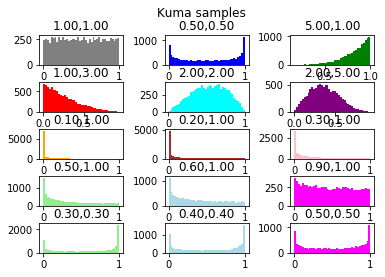

In [9]:
plot_samples(pltconfig, title='Kuma samples')

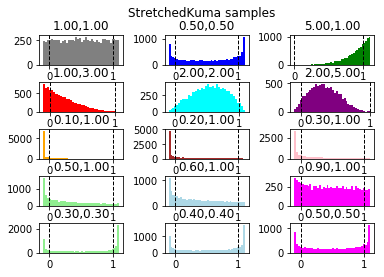

In [10]:
plot_samples(pltconfig, stretch=True, title='StretchedKuma samples')

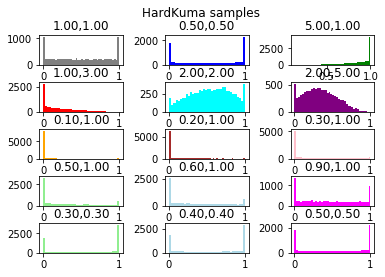

In [11]:
plot_samples(pltconfig, stretch=True, rectify=True, title='HardKuma samples')

## Density

Let's have a look at pdfs. 

*Formally the HardKuma is special because it is not a standard function.*

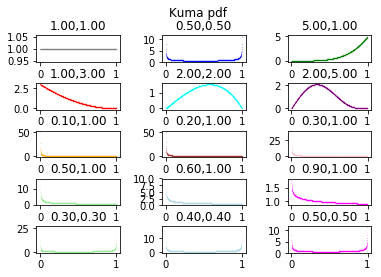

In [12]:
plot_density(pltconfig, title='Kuma pdf')

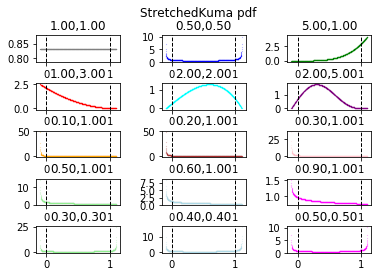

In [13]:
plot_density(pltconfig, stretch=True, title='StretchedKuma pdf')

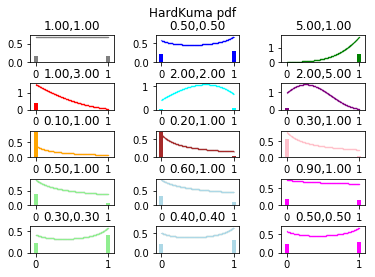

In [14]:
plot_density(pltconfig, stretch=True, rectify=True, title='HardKuma pdf')

# Distribution function

Let's have a look at cdfs


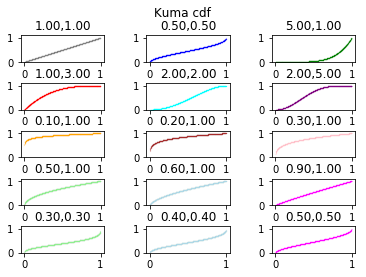

In [15]:
plot_density(pltconfig, cdf=True, title='Kuma cdf')

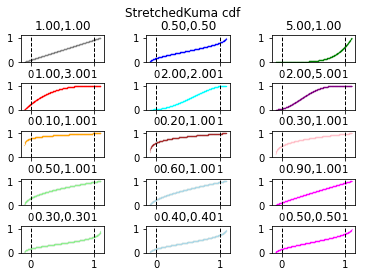

In [16]:
plot_density(pltconfig, cdf=True, stretch=True, title='StretchedKuma cdf')

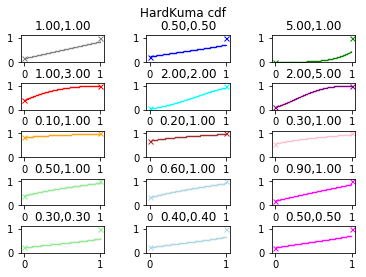

In [17]:
plot_density(pltconfig, cdf=True, stretch=True, rectify=True, title='HardKuma cdf')

## Comparison

In [18]:
def plot_comparison(config, step=0.001, 
             lower=-0.1, upper=1.1, opt='pdf', n=1000, bins=40,
             title='density', filename=''):       
    
    
    k = np.arange(0. + step, 1., step)
    s = np.arange(lower + step, upper, step)
    h = np.concatenate([np.array([0.]), np.arange(0. + step, 1., step), np.array([1.])])
            
    plt.subplots_adjust(wspace=1., hspace=.5)
    #plt.suptitle(title)
    
    def plot_row(row, stretch, rectify):
        for i, (a, b, c) in enumerate(config, 1):
            plt.subplot(3, len(config), len(config) * row + i) 
            p = Kumaraswamy(torch.from_numpy(np.ones([1]) * a), torch.from_numpy(np.ones([1]) * b))
            x = k
            plt.xlim([lower-0.1, upper+0.1])
            if opt == 'cdf':
                plt.ylim(bottom=0.)
                plt.ylim(top=1.1)
            
            if stretch:
                p = stretched_distribution(p, lower=lower, upper=upper)
                x = s
                if rectify:
                    p = StretchedAndRectifiedDistribution(p, lower=lower, upper=upper)
                    x = h
            if row == 0:
                plt.title('K(%.1f, %.1f)' % (a,b), fontsize=8)
            if opt == 'samples':
                y = p.sample(sample_shape=torch.Size([n])).reshape(-1).numpy()
                _ = plt.hist(y, bins, density=False, color=c) 
            elif opt == 'pdf':
                y = np.exp(p.log_prob(torch.from_numpy(x)).numpy())            
                plt.plot(x, y, color=c, linestyle='', marker='.', markersize=0.2)  
                if stretch and rectify:
                    masses = np.exp(p.log_prob(torch.from_numpy(np.array([0., 1.]))).numpy())
                    plt.bar([0., 1.], masses, width=0.07, align='center', color=c)
            else:
                y = p.cdf(torch.from_numpy(x)).numpy()
                plt.plot(x, y, color=c, linestyle='', marker='.', markersize=0.2)            
                if stretch and rectify:
                    masses = p.cdf(torch.from_numpy(np.array([0., 1.]))).numpy()
                    plt.plot([0., 1.], masses, color=c,
                        linestyle='', marker='x', markersize=5)
            if stretch and not rectify:
                plt.axvline(0., color='black', linestyle='dashed', linewidth=1)
                plt.axvline(1., color='black', linestyle='dashed', linewidth=1)
            
    plot_row(0, False, False)
    plot_row(1, True, False)
    plot_row(2, True, True)
    if filename:
        plt.savefig(filename)

Below,
* the top row shows Kumaraswamy pdfs
* the middle row shows stretched Kumaraswamy pdfs
* the bottom row shows stretch-and-rectified Kumaraswamy pdfs

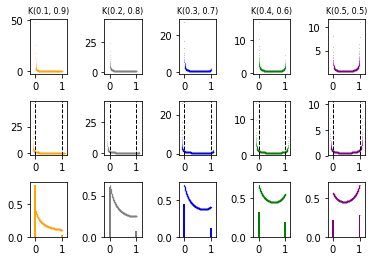

In [19]:
plot_comparison([(0.1, 0.9, 'orange'), (0.2, 0.8, 'gray'), (0.3, 0.7, 'blue'), (0.4, 0.6, 'green'), (0.5, 0.5, 'purple')], 
                title='pdf', opt='pdf', step=0.001, n=1000) 

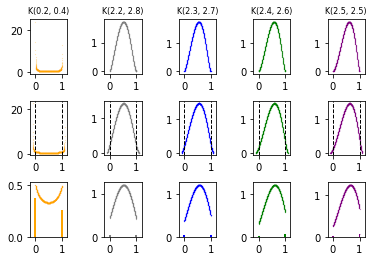

In [20]:
plot_comparison([(0.2, 0.4, 'orange'), (2 + 0.2, 2 + 0.8, 'gray'), (2 + 0.3, 2 + 0.7, 'blue'), (2 + 0.4, 2 + 0.6, 'green'), (2 + 0.5, 2 + 0.5, 'purple')], 
                title='pdf', opt='pdf', step=0.001, n=100) 

## Entropy

We can check the entropy against an MC estimate of it.

**TODO** Is there a problem with the closed-form entropy?

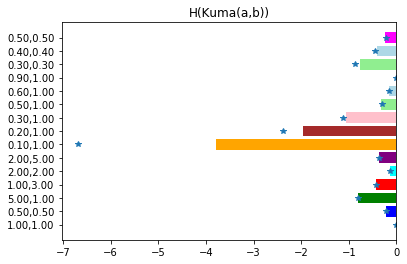

In [21]:
plot_entropy(pltconfig, n_samples=10000, title='H(Kuma(a,b))')

# KL



In [22]:
def plot_kl(config, hard=False, ref=[0.5, 0.5], lower=-0.1, upper=1.1, title='KL',
            runs=1, n_samples=1000):
    plt.subplots_adjust(wspace=3, hspace=0.8)
    plt.suptitle(title)
    
    def plot(to):
        xticks = []        
        colors = []
        patterns = []
        data = []
        p0 = Kumaraswamy(torch.from_numpy(np.ones([1]) * ref[0]), torch.from_numpy(np.ones([1]) * ref[1]))
        if hard:
            p0 = StretchedAndRectifiedDistribution(
                p0,
                lower=lower, 
                upper=upper)
        for run in range(runs):
            y = []
            xticks = []        
            colors = []
            patterns = []
            for i, (a, b, c) in enumerate(config, 1):                
                p = Kumaraswamy(torch.from_numpy(np.ones([1]) * a), torch.from_numpy(np.ones([1]) * b))
                if hard:
                    p = StretchedAndRectifiedDistribution(
                        p, 
                        lower=lower, 
                        upper=upper)
                if to:             
                    y.append(kl_divergence(p, p0))
                else:
                    y.append(kl_divergence(p0, p))
                colors.append(c)
                xticks.append('%.2f,%.2f' % (a,b))
            data.append(y)
        avg = np.mean(data, axis=0)
        if runs > 1:
            std = np.std(data, axis=0)
            plt.barh(np.arange(len(xticks)), avg, color=colors, xerr=std)
        else:
            plt.barh(np.arange(len(xticks)), avg, color=colors)
        plt.yticks(np.arange(len(xticks)), xticks)
    
    plt.subplot(1, 2, 1) 
    plt.title('KL(%sKuma(a,b)||%sKuma(%.2f, %.2f))' % ('Hard' if hard else '', 'Hard' if hard else '', ref[0], ref[1]))
    plot(True)

    plt.subplot(1, 2, 2) 
    plt.title('KL(%sKuma(%.2f, %.2f)||%sKuma(a,b))' % ('Hard' if hard else '', ref[0], ref[1], 'Hard' if hard else ''))
    plot(False)
    

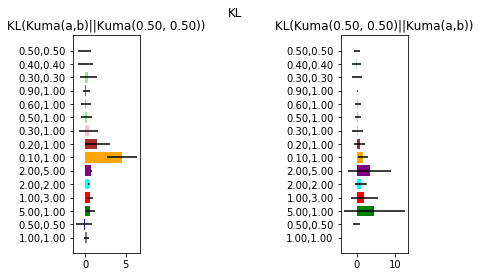

In [23]:
# KL estimates can be negative
plot_kl(pltconfig, runs=100)

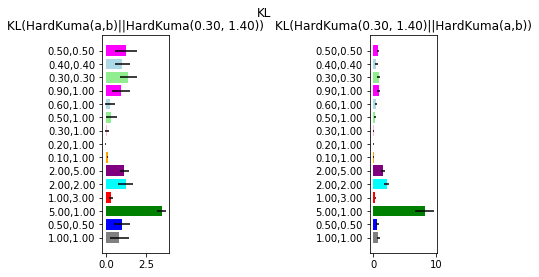

In [24]:
# You might get a warning if ref is also in pltconfig, because I plot error bars and KL(p||p) has no variance
plot_kl(pltconfig, hard=True, runs=10, ref=[0.3, 1.4])

## Truncated Kumaraswamy

For KL computations we need to sample from a truncated Kumaraswamy, here we show how this is done

In [25]:
def plot_truncated_kuma(a, b, step=1e-3, lower=-0.1, upper=1.1, n=1000):
    loc = lower
    scale = upper - lower
    # these are the Kuma variables that correspond to Stretched outcomes 0 and 1
    k0 = - loc / scale
    k1 = (1 - loc) / scale
    # this function maps to the Uniform variable that corresponds to k0 drawn from Kuma(a,b)
    u0fn = lambda shape_a, shape_b: 1 - (1 - k0 ** shape_a) ** shape_b
    # this function maps to the Uniform variable that corresponds to k1 drawn from Kuma(a,b)
    u1fn = lambda shape_a, shape_b: 1 - (1 - k1 ** shape_a) ** shape_b
    # this makes the truncated support as
    #ufn = lambda a, b: np.arange(u0fn(a,b) + step, u1fn(a,b), step)

    # k \in (0, 1)
    x_k = np.arange(0. + step, 1., step)
    # s \in (lower, upper)
    x_s = np.arange(lower + step, upper, step)
    # t \in (0 < k0, k1 < 1)
    x_t = np.arange(k0 + step, k1, step)
    p_k = Kumaraswamy(a=torch.from_numpy(np.ones([1]) * a), b=torch.from_numpy(np.ones([1]) * b))
    p_s = stretched_distribution(p_k, lower=lower, upper=upper)    
    #p_t = Kumaraswamy(a=torch.from_numpy(np.ones([1]) * a), b=torch.from_numpy(np.ones([1]) * b), 
    #                  uniform_support=[u0fn(a, b), u1fn(a, b)])
    
    y_k = np.exp(p_k.log_prob(torch.from_numpy(x_k)).numpy())
    y_s = np.exp(p_s.log_prob(torch.from_numpy(x_s)).numpy())    
    y_t = np.exp(p_k.log_prob(torch.from_numpy(x_t)).numpy())
    plt.title('Kuma(%.2f,%.2f), trunc(%.2f, %.2f), U(%.2f, %.2f)' % (a,b, k0, k1, u0fn(a, b), u1fn(a, b)))
    plt.plot(x_k, y_k, color='gray')
    plt.plot(x_s, y_s, color='blue')
    plt.plot(x_t, y_t, color='red')
    plt.axvline(k0, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(k1, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.axvline(1, color='gray', linestyle='dashed', linewidth=1)
    plt.axvline(lower, color='gray', linestyle='dashed', linewidth=1)
    plt.axvline(upper, color='blue', linestyle='dashed', linewidth=1)
    
    k = p_k.rsample_truncated(k0, k1, 
                              sample_shape=torch.Size([n])).reshape(-1).numpy()
    s = loc + k * scale
    #_ = plt.hist(k, 50, density=True, color='orange')  
    _ = plt.hist(s, 50, density=True, color='gray')  
    plt.xticks(np.arange(-0.2, 1.2, step=0.1))

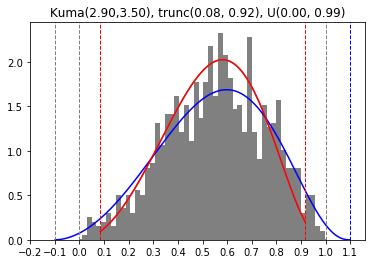

In [26]:
plot_truncated_kuma(2.9, 3.5)

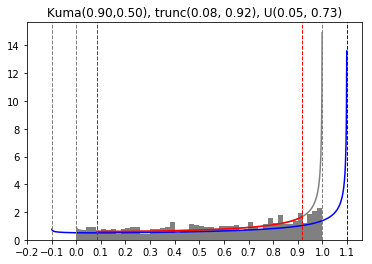

In [27]:
plot_truncated_kuma(0.9, 0.5)

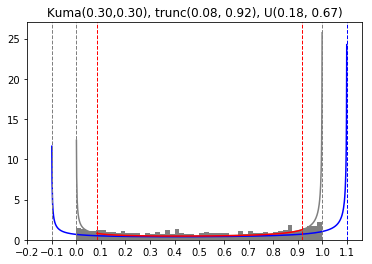

In [28]:
plot_truncated_kuma(0.3, 0.3)

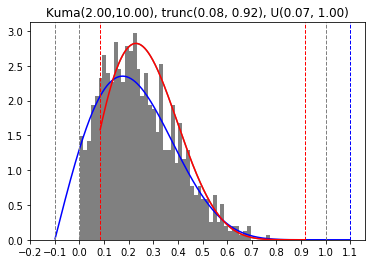

In [29]:
plot_truncated_kuma(2., 10.)